In [ ]:
pip install catboost

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import f1_score, accuracy_score

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

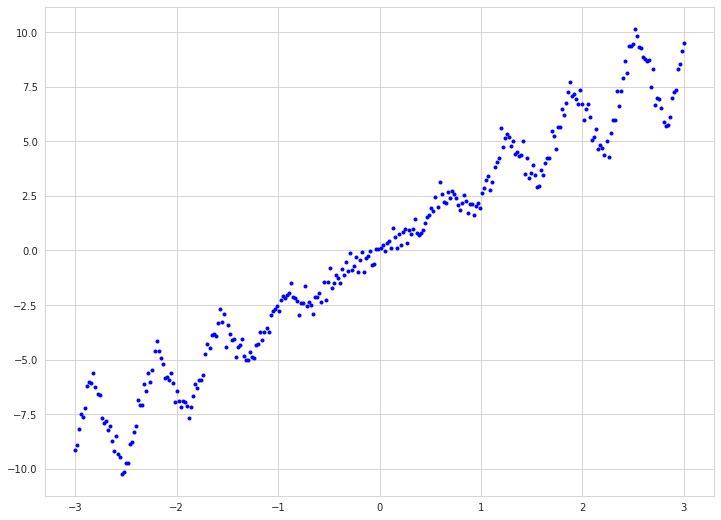

In [ ]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [ ]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, plot_item, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plot_item.scatter(X, y, s=0.5)
    plot_item.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

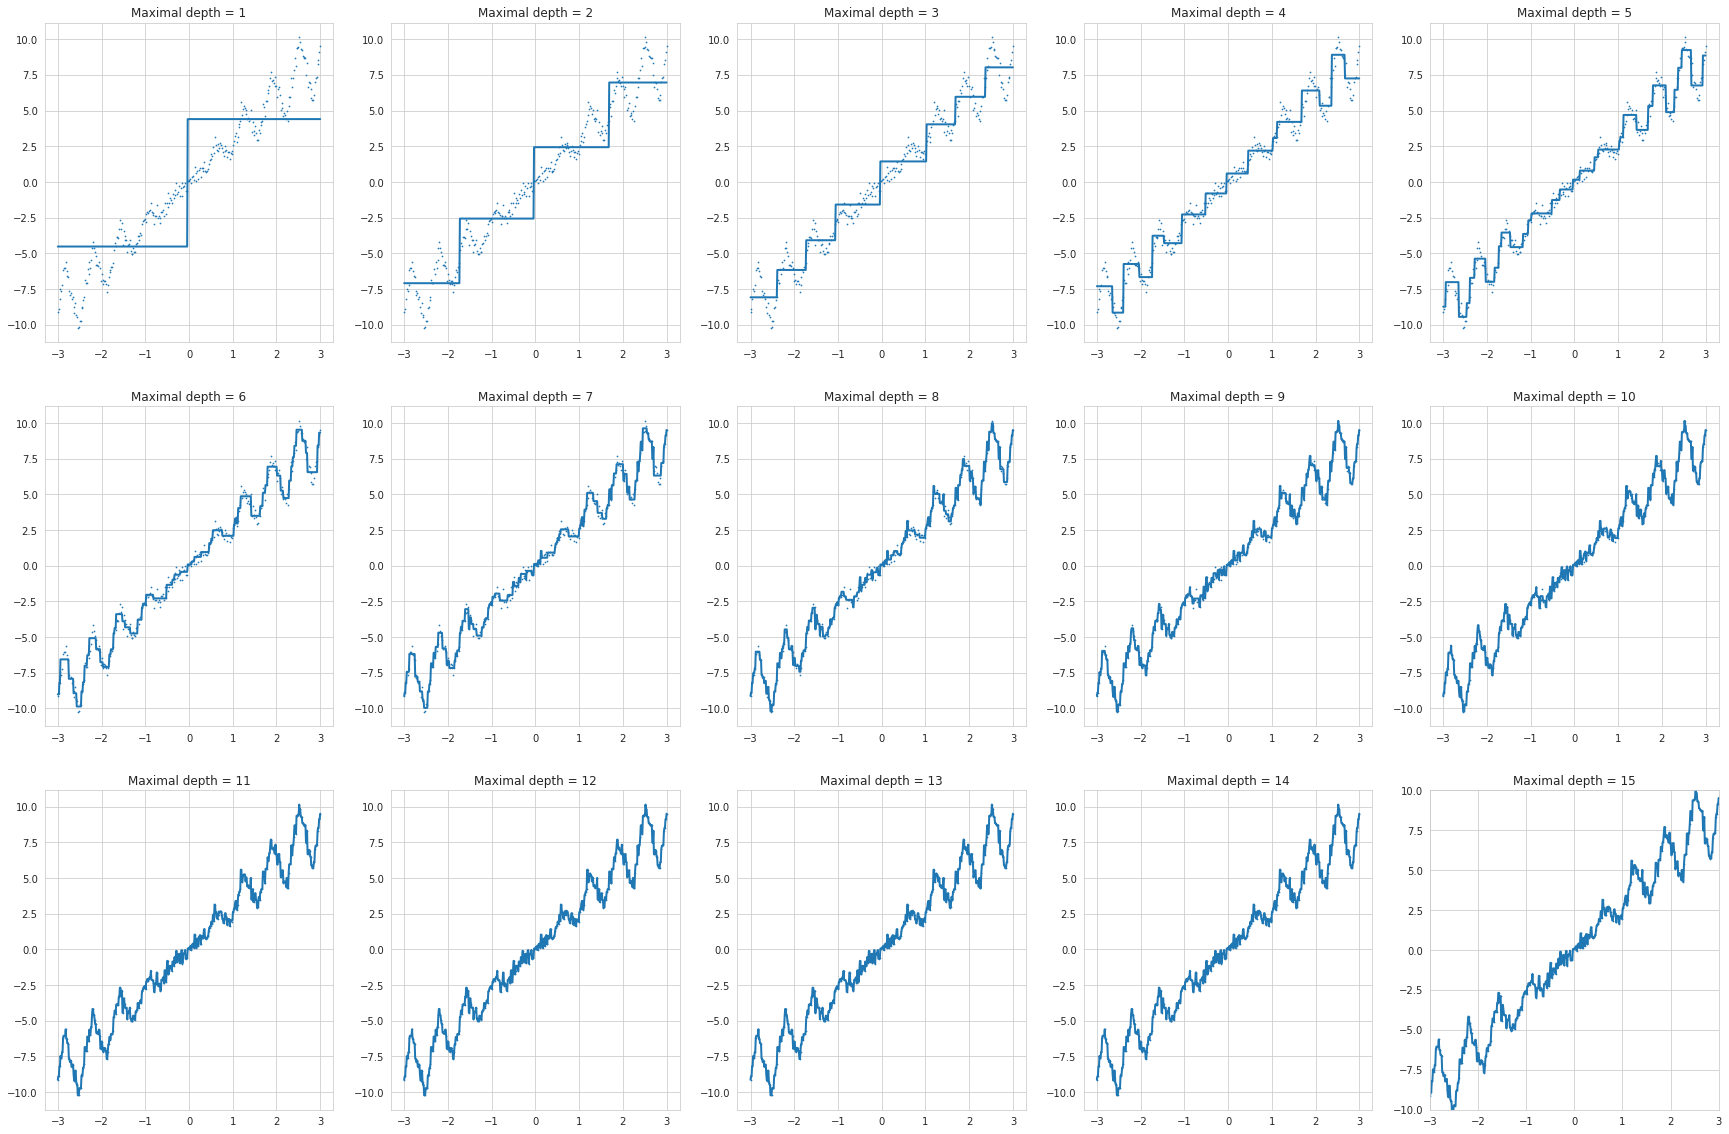

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
axes = axes.flatten()

for i in range(1, 16):
    clf = DecisionTreeRegressor(max_depth=i)
    clf.fit(X, y)
    axes[i-1].set_title(f'Maximal depth = {i}')
    plot_regression_predictions(clf, X, y, axes[i-1])

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

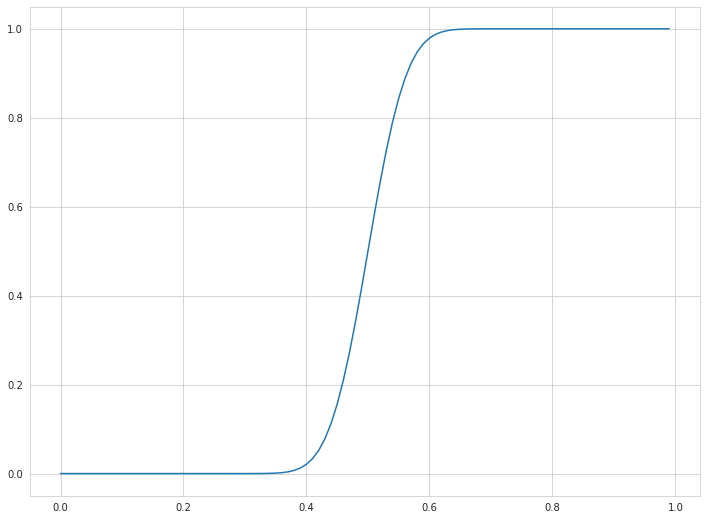

In [ ]:
def get_mu(p, n):
  return np.sum([math.comb(n, i) * p**i * (1-p)**(n - i) for i in range(math.floor(n / 2) + 1, n + 1)])

prob = np.arange(0, 1, 0.01)
mu = np.vectorize(get_mu)(prob, 101)
plt.plot(prob, mu)

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

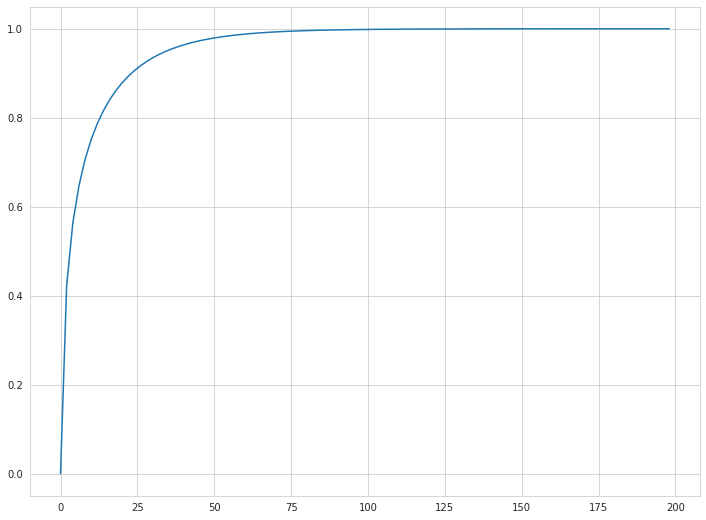

In [ ]:
def get_mu(p, n):
  return np.sum([math.comb(n, i) * p**i * (1-p)**(n - i) for i in range(math.floor(n / 2) + 1, n + 1)])

n = np.arange(0, 200, 2)
mu = np.vectorize(get_mu)(0.65, n)
plt.plot(n, mu)

Опишите ваши наблюдения:

* Судя по графику для получения хорошего результата необходимо,чтобы было больше 100 голосов

* Даже несмотря на то, что каждый отдельны классификатор не особо крутой (всего 0.65 вероятность), но вместе они сила)


#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [ ]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            idxes = np.random.choice(np.arange(X.shape[1]), 
                                        size=self.max_features, 
                                        replace=False)
            self.feat_ids_by_tree.append(idxes)
            sample_idx = np.random.choice(np.arange(X.shape[0]), 
                                          size=X.shape[0], 
                                          replace=True)
            X_sample = X[sample_idx][:, idxes]
            y_sample = y[sample_idx]
            clf = DecisionTreeClassifier(
                max_depth=self.max_depth, 
                max_features=self.max_features, 
                random_state=self.random_state+i)
            clf.fit(X_sample, y_sample)
            self.trees.append(clf)
        return self
      

    def predict_proba(self, X):
      ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        y_pred = []
        for tree, feat in zip(self.trees, self.feat_ids_by_tree):
            y_pred.append(tree.predict_proba(X[:, feat]))          
        return np.average(y_pred, axis = 0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

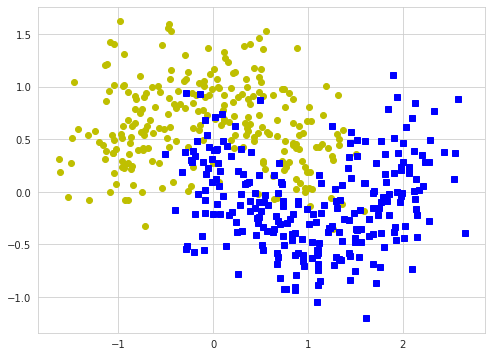

In [ ]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

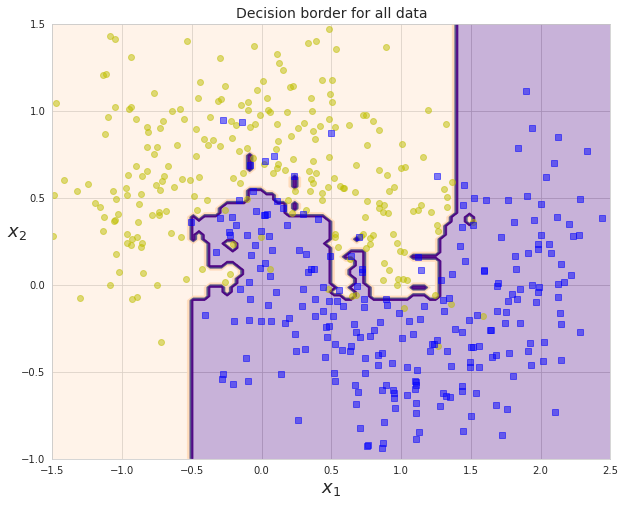

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(10, 8))
custom_clf = RandomForestClassifierCustom(max_depth=10, n_estimators=100,
                                  max_features=2, random_state=SEED)
custom_clf.fit(X_train, y_train)
plot_decision_boundary(custom_clf, X, y)
plt.title("Decision border for all data", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

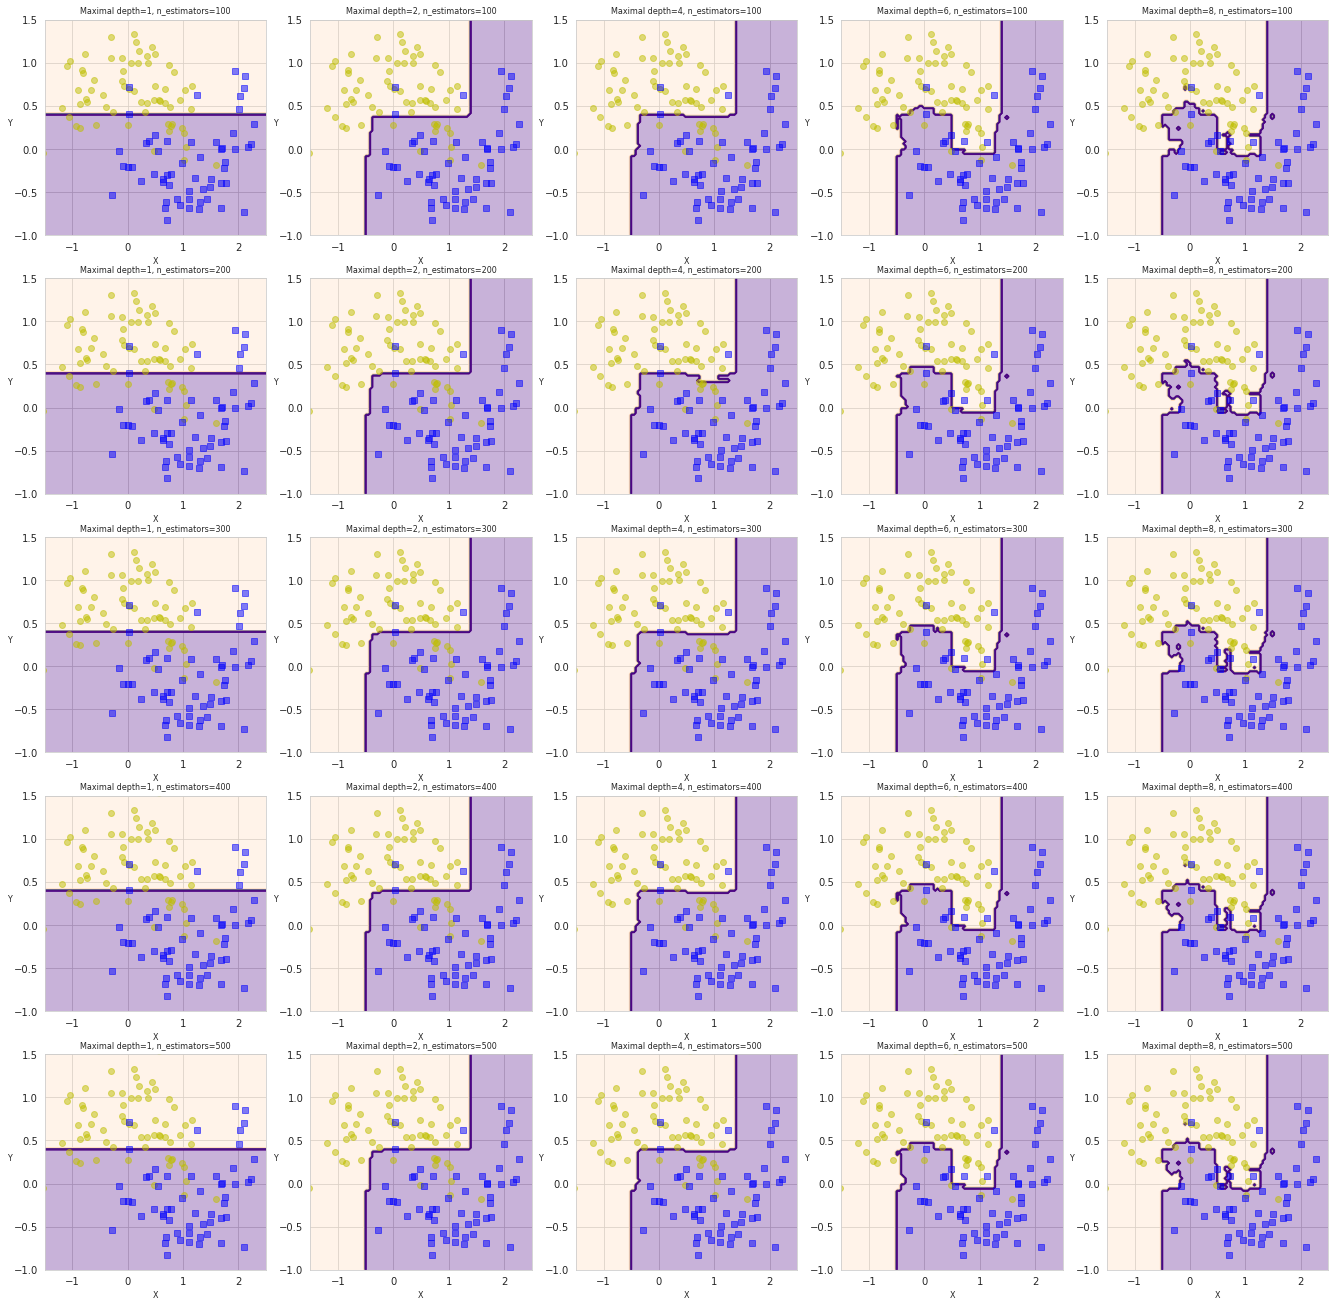

In [ ]:
figs = plt.figure(figsize=(23,23))
i = 1
depthes = [1, 2, 4, 6, 8]
n_estimators = range(100, 600, 100)

for estimator in n_estimators:
  for depth in depthes:
    rf = RandomForestClassifierCustom(max_depth=depth, n_estimators=estimator, 
                                      max_features=2, random_state=SEED)
    rf.fit(X_train, y_train)
    figs.add_subplot(5, 5, i)
    plot_decision_boundary(rf, X_test, y_test)
    plt.title(f'Maximal depth={depth}, n_estimators={estimator}', fontsize=8)
    plt.xlabel('X', fontsize=8)
    plt.ylabel('Y', fontsize=8)
    i += 1

Посмотрела на разделяющую границу для тестовых данных. Ну вроде симпатично выглядят случаи с maximal depth = 8 и n = 100

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [ ]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [ ]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Погуглила. Это данные "The breast cancer dataset", в них 30 фич.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
corrs = []
for number in range(1, 30, 2):
    rf = RandomForestClassifier(max_features=number)
    rf.fit(X_train, y_train)
    corrs.append(base_model_pair_correlation(rf, X_test))

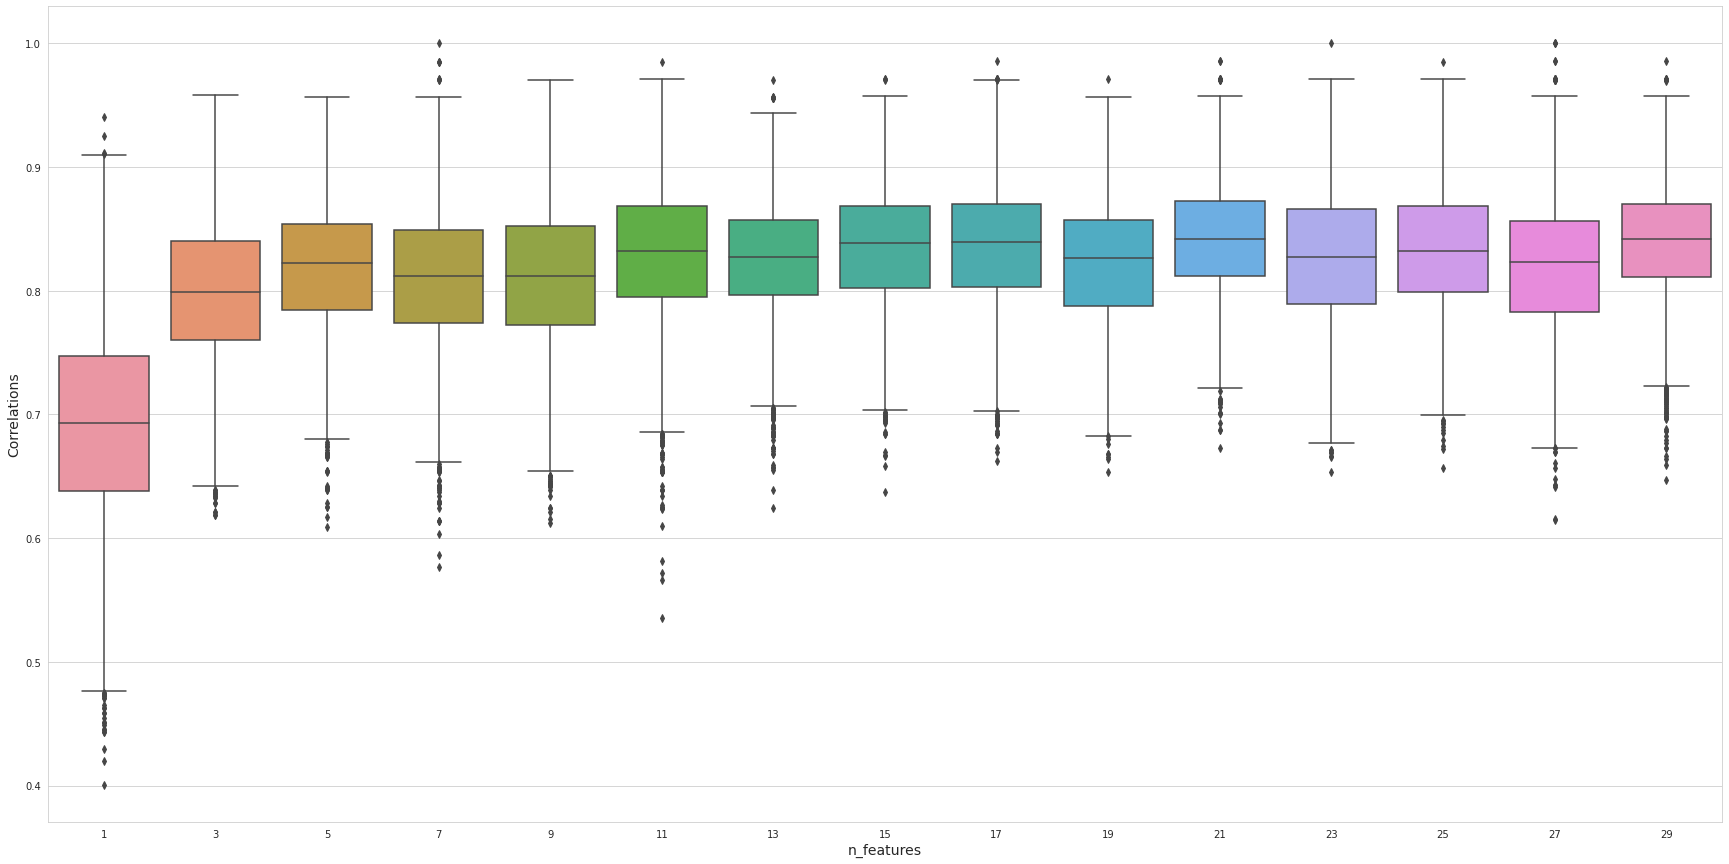

In [ ]:
plt.figure(figsize=(30, 15))
sns.boxplot(data=pd.DataFrame(np.array(corrs).T, columns=range(1, 30, 2)))
plt.xlabel('n_features', fontsize=14)
plt.ylabel('Correlations', fontsize=14)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
corrs = []
for number in range(1, 20):
    rf = RandomForestClassifier(max_depth=number)
    rf.fit(X_train, y_train)
    corrs.append(base_model_pair_correlation(rf, X_test))

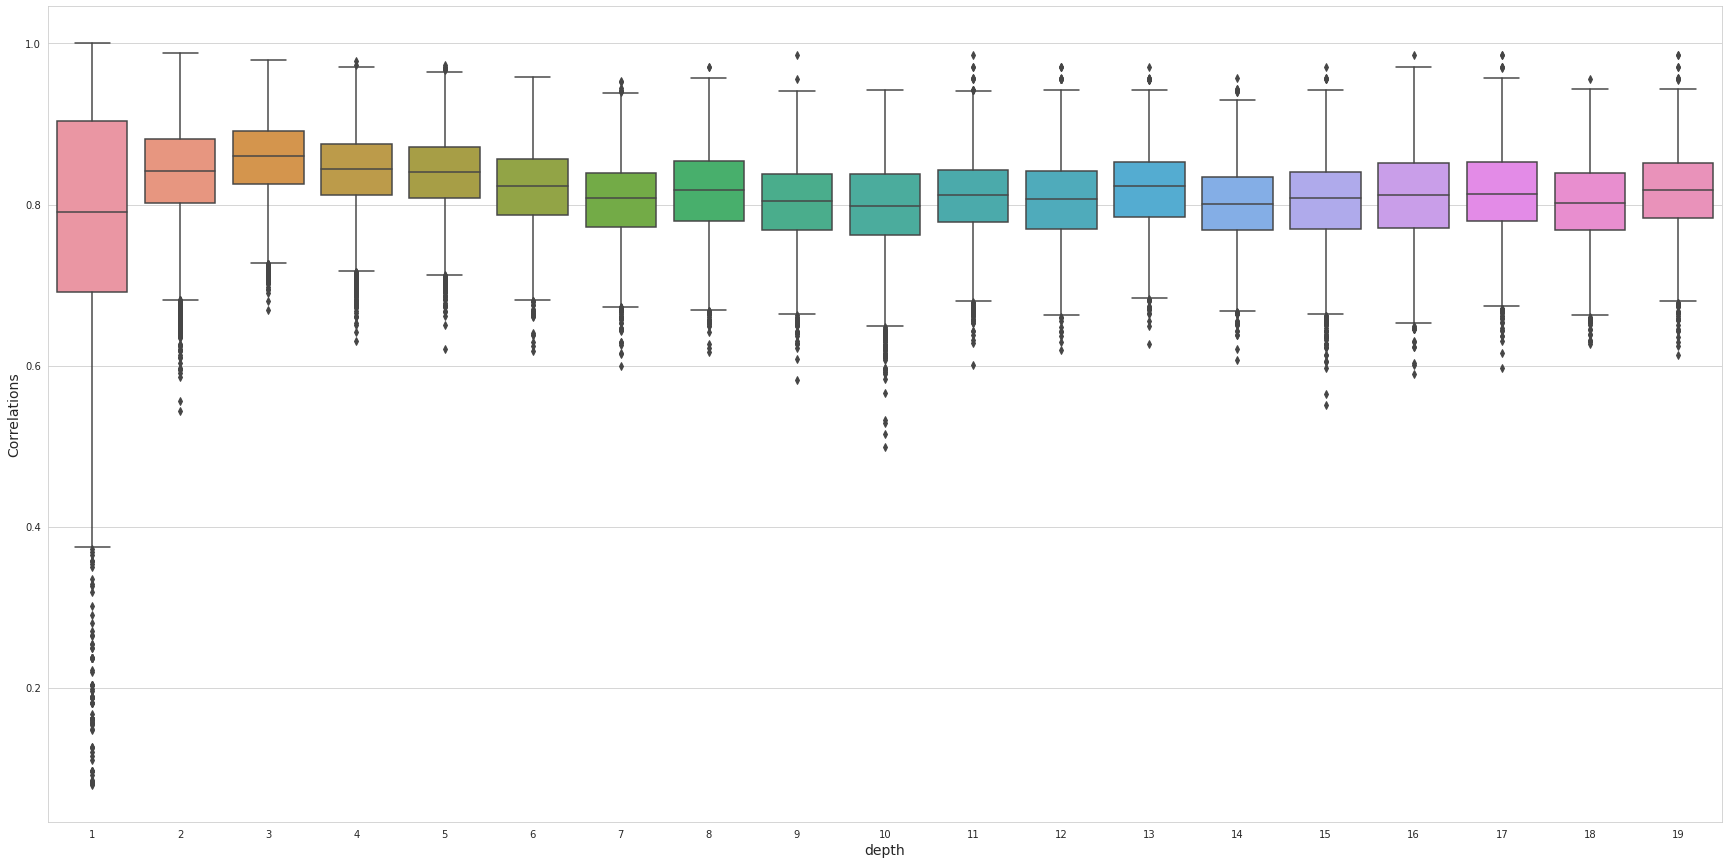

In [ ]:
plt.figure(figsize=(30, 15))
sns.boxplot(data=pd.DataFrame(np.array(corrs).T, columns=range(1, 20)))
plt.xlabel('depth', fontsize=14)
plt.ylabel('Correlations', fontsize=14)
plt.show()

Опишите ваши наблюдения:

* Увеличивая пераметр max_features, мы увеличиваем корреляцию эстиматоров (в нашем случае с какого-то момента она достигает 0.83 примерно)
* При варьировании max_depths поведение менее предсказуемо, в целом значения колеблются вблизи 0.8


### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [3]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [5]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [32]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8426829268292683
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [8]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

Буду работать с voting soft, гляну, что скоррелировано

In [47]:
voting_soft.fit(X_train, y_train)
corrs = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

corrs = base_model_pair_correlation_for_voting_clf(voting_soft, X)
for item in corrs:
  if item[2] > 0.92:
    print(item)

(ExtraTreesClassifier(random_state=111), LGBMClassifier(random_state=111), 0.9631692702692505)
(LGBMClassifier(random_state=111), XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=111,
                reg_alpha=None, ...), 0.9623033313559383)


In [49]:
uncorr_base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

voting_soft = VotingClassifier(uncorr_base_models, voting='soft')
voting_soft.fit(X_train, y_train)
f1_score(y_test, voting_soft.predict(X_test))

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


0.854368932038835


Ну как и обещает спойлер, чуда не произошло( 
Посмотрю по f1, какое сочетание лучше:

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
from itertools import chain, combinations
def all_subsets(sets):
    return chain(*map(lambda x: combinations(sets, x), range(0, len(sets)+1)))
good_res = []

for subset in all_subsets(base_models):
    if len(subset) > 1:
      voting_soft = VotingClassifier(list(subset), voting='soft')
      voting_soft.fit(X_train, y_train)
      score = f1_score(y_test, voting_soft.predict(X_test))
      if score > 0.91:
        good_res.append((subset, score))

Ну брутфорсинг недолгий дал, напрмер, вот такое сочетание: ETC, LR, NB

In [45]:
print('\n'.join(str(item) for item in good_res))

((('ETC', ExtraTreesClassifier(random_state=111)), ('LR', LogisticRegression(max_iter=10000, solver='liblinear')), ('NB', GaussianNB())), 0.9166666666666666)


In [52]:
best_base_models = [("ETC", etc),("LR", lr), ("NB", nb)]

voting_soft = VotingClassifier(best_base_models, voting='soft')
voting_soft.fit(X_train, y_train)
print(f'f1 = {f1_score(y_test, voting_soft.predict(X_test))}')
print(f'cross_val = {cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1").mean()}')

f1 = 0.9166666666666666
cross_val = 0.8326137221815965


Фиговый cross_val вышел, посмотрим поперебираем по нему

In [ ]:
from itertools import chain, combinations
def all_subsets(sets):
    return chain(*map(lambda x: combinations(sets, x), range(0, len(sets)+1)))
good_res = []

for subset in all_subsets(base_models):
    if len(subset) > 1:
      voting_soft = VotingClassifier(list(subset), voting='soft')
      voting_soft.fit(X_train, y_train)
      score = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1").mean()
      if score > 0.88:
        good_res.append((subset, score))

In [55]:
print('\n'.join(str(item) for item in good_res))

Неуспех( Ну я не стала на всю ночь оставлять, может, оставь я надолго это крутиться, он бы что-то нашёл...

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [43]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [44]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [45]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [46]:
data=data.rename(columns={"Churn?":"Churn"})

Думаю, нам не нужен номер телефона.

In [47]:
data = data.drop(['Phone', 'State'], axis=1)

Сделаем целевую пременную более адекватной:

In [48]:
data.Churn.replace({'False.': 0, 'True.': 1}, inplace=True)

Ой, ещё про yes-no забыла, их бы тоже норм булевыми сделать

In [49]:
data.replace({'yes': 1, 'no': 0}, inplace=True)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account Length  3333 non-null   int64  
 1   Area Code       3333 non-null   int64  
 2   Int'l Plan      3333 non-null   int64  
 3   VMail Plan      3333 non-null   int64  
 4   VMail Message   3333 non-null   int64  
 5   Day Mins        3333 non-null   float64
 6   Day Calls       3333 non-null   int64  
 7   Day Charge      3333 non-null   float64
 8   Eve Mins        3333 non-null   float64
 9   Eve Calls       3333 non-null   int64  
 10  Eve Charge      3333 non-null   float64
 11  Night Mins      3333 non-null   float64
 12  Night Calls     3333 non-null   int64  
 13  Night Charge    3333 non-null   float64
 14  Intl Mins       3333 non-null   float64
 15  Intl Calls      3333 non-null   int64  
 16  Intl Charge     3333 non-null   float64
 17  CustServ Calls  3333 non-null   i

Ну норм. Посмотрю на корреляции:

<Axes: >

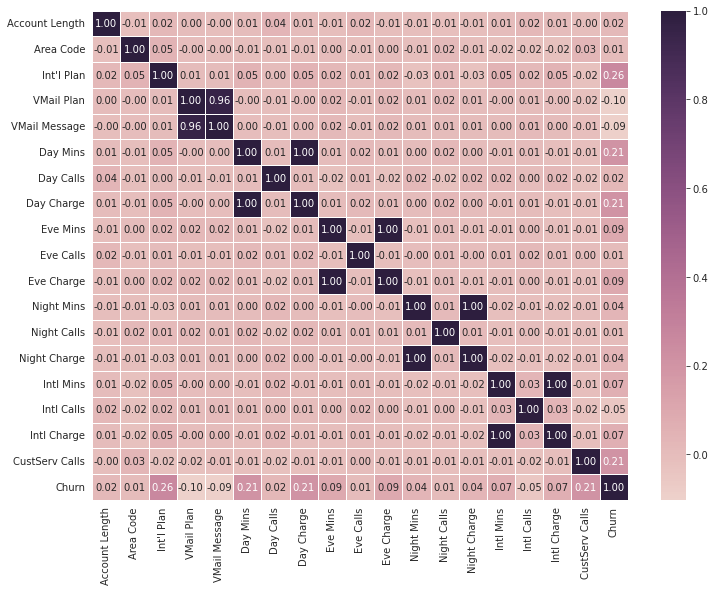

In [52]:
sns.heatmap(data.corr(), linewidths=1, annot=True, fmt=".2f", cmap=sns.cubehelix_palette(as_cmap=True))

Ой, лучше б выкинуть что-то из такого скоррелированного

In [53]:
data = data.drop(["VMail Plan", "Day Mins", "Eve Mins", "Night Mins", "Intl Mins"], axis=1)

<Axes: >

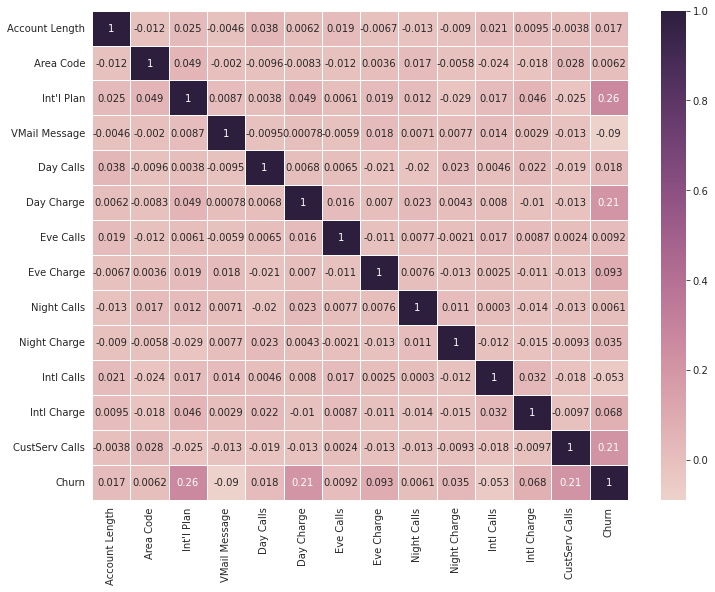

In [54]:
sns.heatmap(data.corr(), linewidths=1, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

Ну всё, теперь мне всё нравится

In [116]:
y, X = data["Churn"], data.drop(["Churn"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=SEED)

Попробую эти модели, пооптимизирую их через `GridSearchCV`:

1. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
2. `lightgbm.LGBMClassifier`

In [122]:
cross_val = KFold(n_splits=5, shuffle=True, random_state=SEED)
model = lightgbm.LGBMClassifier(objective='binary', n_jobs=-1, random_state=SEED)
params = {
    'max_depth': [1, 10,  50],
    'n_estimators':[1, 20 ,100],
    'reg_alpha': [0, 0.2, 1],
    'reg_lambda': [0, 0.2, 1],
    }

best_model = GridSearchCV(model, param_grid=params, cv=cross_val)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [123]:
print(f'The best estimator is {best_model.best_estimator_},  accuracy_score = {accuracy_score(y_test, y_pred)}')

The best estimator is LGBMClassifier(max_depth=50, objective='binary', random_state=111,
               reg_alpha=0.2, reg_lambda=0.2),  accuracy_score = 0.954


In [124]:
cross_val = KFold(n_splits=5, shuffle=True, random_state=SEED)
model = xgboost.XGBRFClassifier(n_jobs=-1, random_state=SEED)
params = {
    'max_depth': [1, 10,  50],
    'n_estimators':[1, 20 , 100],
    'reg_alpha': [0, 0.2, 1],
    'reg_lambda': [0, 0.2, 1],
    }

best_model = GridSearchCV(model, param_grid=params, cv=cross_val)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [125]:
print(f'The best estimator is {best_model.best_estimator_},  accuracy_score = {accuracy_score(y_test, y_pred)}')

The best estimator is XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=10, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=-1, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=111,
                reg_alpha=0.2, ...),  accuracy_score = 0.948


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

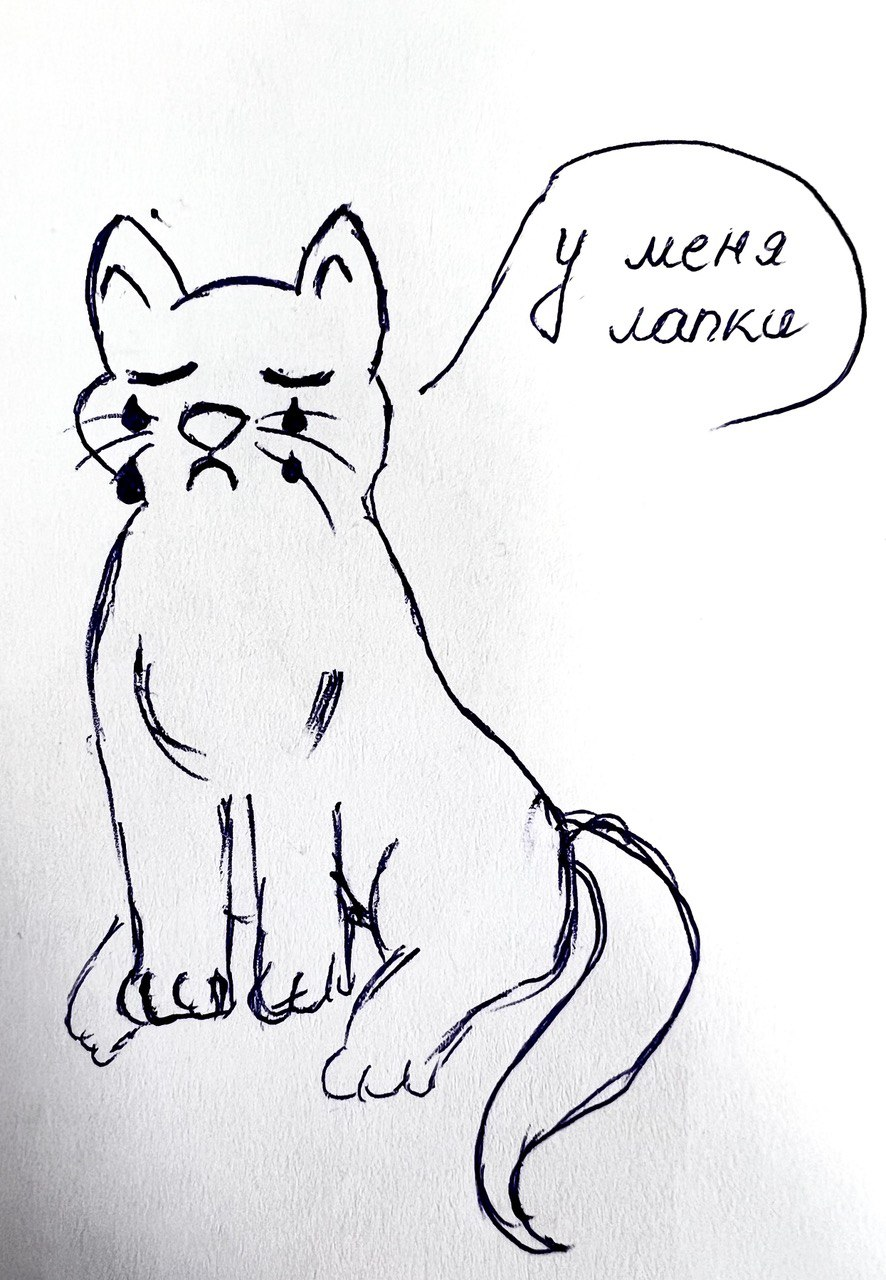

In [126]:
from IPython.display import Image
Image("AAA.jpg")

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**